## Required Packages & Setup

Modern language models are often trained on hundreds of gigabytes of data and can't be easily replicated as a course project. In this project, we'll show how to use existing pre-trained transformer language models with the Python [`transformers` library](https://huggingface.co/docs/transformers/index).

In [ ]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import tqdm
import random
import pdb
import regex as re
import seaborn as sns

!pip install torch
import torch
from torch import nn
import torch.nn.functional as F

### Inference with Autoregressive Models

We'll start by computing word probabilities under the autoregressive [GPT-2 model](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). To do so, we'll install the `transformers` library, which isn't natively installed on Google Colaboratory. We'll import a pre-trained `GPT2LMHeadModel` and its corresponding tokenizer, `GPT2TokenizerFast`. Note that without additional training, you can't freely mix-and-match models and their corresponding tokenizers! We aren't using the largest available models, such as [GPT-3](https://arxiv.org/abs/2005.14165), because they do not provide free inference. Larger freely available models such as [GPT-J](https://huggingface.co/EleutherAI/gpt-j-6B) do exist though, and you should feel free to play around with them.

In [ ]:
!pip install transformers
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

The following code downloads model weights and can take a few minutes to run. For debugging purposes, feel free to swap out `gpt2-large` with a smaller model that downloads faster. Note that predictions made by `gpt-medium` and `gpt-small` are trained with less samples, implying lower predictive power.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
    print("Running on GPU")
else:
    device = "cpu"
    print("Running on CPU")

model = GPT2LMHeadModel.from_pretrained("gpt2-large").to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2-large")

Running on GPU


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


We'll extract the vocabulary from the tokenizer so that we can easily see the words we're dealing with:

In [ ]:
# Vocab Map
vocab_map = {}
vocab = tokenizer.vocab
for token in tqdm.tqdm(vocab):
    idx = vocab[token]
    vocab_map[idx] = token

100%|██████████| 50257/50257 [00:00<00:00, 1041679.08it/s]


We can use our tokenizer to convert sentences into tensors and use `vocab_map` to see what indices of these tensors correspond to. This will show which words are broken into subwords by the GPT-2 tokenizer. Note that `<|endoftext|>` is equivalent to `<eos>` in the previous notebook:

In [ ]:
# Example Sentence Encoding
sentence = "<|endoftext|>I love LTSMs"
encodings = tokenizer(sentence, return_tensors='pt')
print(encodings["input_ids"])
print([vocab_map[int(idx)] for idx in encodings["input_ids"][0]])

tensor([[50256,    40,  1842,   406,  4694, 10128]])
['<|endoftext|>', 'I', 'Ġlove', 'ĠL', 'TS', 'Ms']


As we can see from the above example, rare words like "LSTMs" are broken into multiple subwords by the GPT-2 tokenizer. Additionally, note that the token "Ġ" corresponds to a blank space, so we can reconstruct word boundaries from the tokenizer outputs. Given a sentence, we'll now use GPT-2 to compute contextual word probabilities for every word. Some hints for doing this:


* Check the documentation for the GPT2LMHeadModel here: https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel
* Begin by adding the `<|endoftext|>` token and passing the sentence into the tokenizer, as shown above
* Compute word probabilities by taking `model(input_ids).logits`
* Then, you'll need to `softmax` and index into the logits using `torch.gather` (the hardest part)
* Finally, convert to word probabilities (rather than subword probabilities) using `vocab_map` and the "Ġ" token



In [ ]:
def get_gpt_probs(sentence):
    words = []
    probs = []
    sentence = "<|endoftext|>" + sentence
    encodings = tokenizer(sentence, return_tensors='pt')
    input_ids = encodings["input_ids"].to(device)
    logits = model(input_ids).logits
    logits = F.log_softmax(logits, dim=-1).squeeze(0)

    p = torch.gather(logits, dim=-1, index=input_ids.squeeze(0).unsqueeze(-1)[1:]).flatten().tolist()
    w = [vocab_map[int(idx)] for idx in encodings["input_ids"][0]][1:]
    assert len(p) == len(w)

    word = ""
    prob = 0
    for i in range(len(w)):
      word += w[i]
      prob += p[i]
      if i+1 == len(w) or w[i+1][0] == "Ġ":
        words.append(word)
        probs.append(-prob)
        word = ""
        prob = 0

    # # END SOlUTION
    return [(word, prob) for word, prob in zip(words, probs)]

get_gpt_probs("The florist sent the flowers was pleased.")

[('The', 2.4790923595428467),
 ('Ġflorist', 13.309796154499054),
 ('Ġsent', 8.142409324645996),
 ('Ġthe', 2.366190195083618),
 ('Ġflowers', 1.4056129455566406),
 ('Ġwas', 9.130632400512695),
 ('Ġpleased.', 9.912347078323364)]

In [ ]:
# To check that your implementation is roughly correct:
def compare_probs(predictions, gold):
  assert len(predictions) == len(gold)
  for x,y in zip(predictions, gold):
    assert np.abs(x[1]-y[1]) < 0.01
  print("Passed")

predictions = get_gpt_probs("The florist sent the flowers was pleased.")
gold = [('The', 2.4790916442871094), ('Ġflorist', 13.309800148010254), ('Ġsent', 8.14240837097168), ('Ġthe', 2.3661890029907227), ('Ġflowers', 1.4056150913238525), ('Ġwas', 9.130632400512695), ('Ġpleased.', 9.912347793579102)]
compare_probs(predictions, gold)

predictions = get_gpt_probs("I like LSTMs")
gold = [('I', 4.226133823394775), ('Ġlike', 5.041623115539551), ('ĠLSTMs', 17.857036590576172)]
compare_probs(predictions, gold)

Passed
Passed


We wrote some plotting code so you can visualize these probabilities for individual sentences. Note that this code might break on unusually long sentences, but we've provided a couple of examples below:

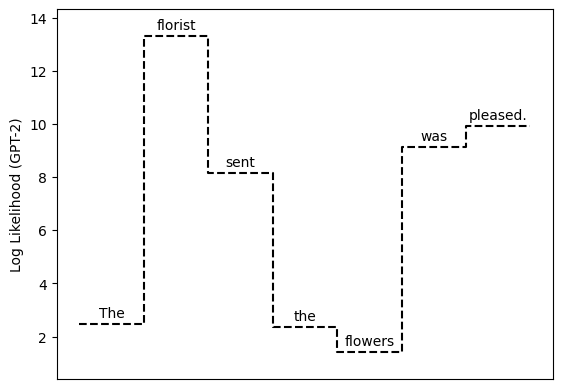

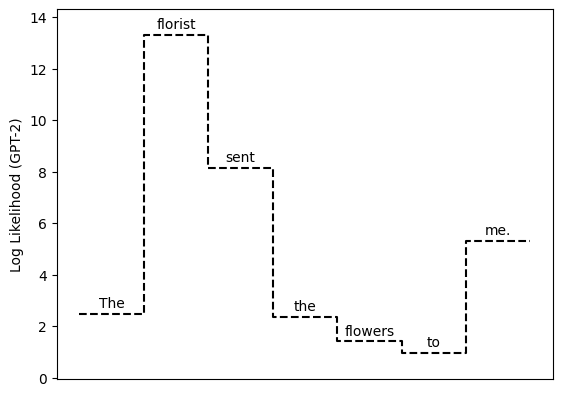

In [ ]:
def plot_gpt_probs(sentence):
  words = sentence.split()
  probs = get_gpt_probs(sentence)
  assert len(words) == len(probs)
  probs = np.asarray([probs[0][1]] + [prob[1] for prob in probs])
  x = np.arange(len(probs))
  plt.step(x, probs, where="pre", color="black", linestyle="dashed")
  text_x = (x[1:] + x[:-1])/2
  text_y = probs[1:] + 0.25
  for idx in range(len(words)):
      plt.text(text_x[idx], text_y[idx], words[idx], ha="center")
  plt.ylim([min(probs)-1, max(probs)+1])
  plt.xticks()
  plt.ylabel("Log Likelihood (GPT-2)")
  plt.tick_params(
      axis='x',
      which='both',
      bottom=False,
      top=False,
      labelbottom=False)
  plt.show()

plot_gpt_probs("The florist sent the flowers was pleased.")
plot_gpt_probs("The florist sent the flowers to me.")

The first sentence above is an example of a [garden-path sentence](https://en.wikipedia.org/wiki/Garden-path_sentence). Even though it's a fairly common word, "was" is assigned low probability because it's unlikely in the context; other words like "florist" and "pleased" are also low probability, but they're rarer across all contexts they appear in (i.e., lower unigram probability). The second sentence shows a non-garden-path continuation with much higher probability.

One downside of transformer language models is that they have a fixed length, so [computing perplexity can be expensive](https://huggingface.co/transformers/v3.2.0/perplexity.html). Although using a sliding window is the most principled way to compute perplexity with GPT-2, [striding can also provide good results with faster inference](https://arxiv.org/pdf/2012.15832.pdf). Next, we'll modify our existing function to handle longer sequences. Our model has an effective context length of 1024 tokens, and we'll use a stride of 512. This means that every token will be predicted with at least 512 tokens in the context.

In [ ]:
stride = 512
print("Context length: {}".format(model.config.n_positions))
max_length = model.config.n_positions

Context length: 1024


In [ ]:
def get_gpt_probs(document, stride=512):

    # YOUR CODE HERE

    # BEGIN SOLUTION

    words = []
    probs = []

    ## handle first 512 seperately (no context)
    encodings = tokenizer('<|endoftext|>' + document, return_tensors='pt')
    map = [vocab_map[int(idx)] for idx in encodings["input_ids"][0]] # list of input ids

    total = encodings.input_ids.squeeze(0).to(device)

    first = total[:stride]
    with torch.no_grad():
      logits = model(first).logits.squeeze(0)
      logits = F.log_softmax(logits.to(device), dim = 1).view(len(first), -1)
      first = torch.gather(logits, dim = 1, index = total[1:stride].unsqueeze(-1)).squeeze().tolist()
      probs.extend(first)

    ## batching takes too much memory(I think) - there would be a resulting ~227 lists of length 1024 that would need to be stored
    ## let's try a good old fashioned for-loop & append method; we will replace the list in memory each time to save space
    start = 0
    end = max_length

    with torch.no_grad():
      while(end < len(total)):
        current = total[start:end]
        logits = model(current).logits.squeeze(0)
        logits = F.log_softmax(logits.to(device), dim = 1).view(len(current), -1)
        current = torch.gather(logits, dim = 1, index = total[start+512:end].unsqueeze(-1)).squeeze().tolist()
        probs.extend(current)
        start+=512
        end+=512

    last = total[-max_length:]
    with torch.no_grad():
      logits = model(last).logits.squeeze(0)
      logits = F.log_softmax(logits.to(device), dim = 1).view(len(last), -1)
      current = torch.gather(logits, dim = 1, index = total[232448:].unsqueeze(-1)).squeeze().tolist()
      probs.extend(current)

    assert len(map[1:]) == len(probs)


    new_dict = {subword:abs(prob) for subword,prob in zip(map[1:],probs)}

    ## prepare to concatenate
    res = []
    total_word = ''
    total_prob = 0

    ## play around with dictionary we made from the logit table
    for i in range(len(map)):

        ## skip the first case
        if i == 0:
            continue

        ## hold the current word and its respective probability prob the dictionary
        word = map[i]
        prob = new_dict[word]

        ## finding a 'G' means that we reset our "holding" variables
        if 'Ġ' in word:
            ## new item in the list
            res.append((total_word, total_prob))
            total_word = ''
            total_prob = 0

        ## for tokens without starter add to previous one until we see another starter character again
        total_word = total_word + word
        total_prob = total_prob + prob

    ## everything in tuple form for zip & comparison
    res.append((total_word,total_prob))

    return res

We'll now compute the probabilities of every word in Pride and Prejudice using GPT-2. Note that this will take a very long time to run with a small stride, so you're encouraged to get the implementation of striding correct.

In [ ]:
!wget https://cal-cs288.github.io/sp22/project_files/hw1/pride.txt
with open("pride.txt", "r") as infile:
  text = infile.read()
output = get_gpt_probs(text, stride=512)
probs = np.asarray([val[1] for val in output])
np.save("word_probs.npy", probs)
torch.cuda.empty_cache()

--2024-03-08 22:23:33--  https://cal-cs288.github.io/sp22/project_files/hw1/pride.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 796805 (778K) [text/plain]
Saving to: ‘pride.txt.2’

pride.txt.2         100%[===================>] 778.13K  --.-KB/s    in 0.03s   

2024-03-08 22:23:33 (22.9 MB/s) - ‘pride.txt.2’ saved [796805/796805]



Token indices sequence length is longer than the specified maximum sequence length for this model (232946 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# check that our result file indeed contains strided probabilities
output[:10]

[('ï»¿Chapter', 39.905624866485596),
 ('Ġ1ĊĊ', 37.768104553222656),
 ('Ġ', 18.350669860839844),
 ('Ġ', 18.350669860839844),
 ('Ġ', 18.350669860839844),
 ('Ġ', 18.350669860839844),
 ('Ġ', 18.350669860839844),
 ('ĠIt', 17.99120330810547),
 ('Ġis', 21.256128311157227),
 ('Ġa', 18.57893180847168)]

### Prompting with Language Models

Language models can be coerced into performing a variety of different tasks via *prompting*, as shown in the [GPT-3 paper](https://arxiv.org/abs/2005.14165). At a high level, prompting involves putting a few training examples into the context of a model and then using next word prediction to predict labels. In this sextion, we'll use prompting and the GPT-2 Large model on the sentiment task SST-2. But first, we'll download the dataset:

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")

In [ ]:
dataset["test"][20]

{'sentence': 'some , like ballistic , arrive stillborn ... looking like the beaten , well-worn video box cover of seven years into the future .',
 'label': -1,
 'idx': 20}

Now, it's time to write a prompt for sentiment prediction. Here's an example what a prompt might look like for the task of machine translation:


```
The French "Le Tea Party est atterré." in English is "The tea party is aghast"
The French "Cela est vraiment indispensable pour notre nation." in English is "This really is a must for our nation."
The French "Il va y avoir du changement dans la façon dont nous payons ces taxes." in English is "There is going to be a change in how we pay these taxes."
The French "La technologie est là pour le faire." in English is
```
The model would then predict the next tokens, hopefully resulting in an English translation of the final sentence. Note that these examples are all taken from the `wmt14` translation dataset. In our case, however, we'll be predicting sentiment, which is represented by a binary value in the Stanford Sentiment Treebank. To convert next-word predictions into a binary decision, we'll compute the probability of two words (e.g., "yes" vs. "no") and then choose our label based on whichever one has the highest probability.

In [ ]:
prompt = "The sentiment of 'love is a compelling part of human nature' is good. \
            The sentiment of 'an ugly distressing repetitive pattern' is bad. The sentiment \
            of 'wonderful joyous refreshing days ahead' is good. The sentiment of 'depression \
            is a sad but troubling part of life' is bad. The sentiment of 'the broken wine \
            glass bled sluggishly onto the carpet' is bad. The sentiment of '{}' is ".format(sentence)

def predict_sentiment(sentence):

  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)

  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][14774] ; pos = probs[-1][11274]

  if neg > pos:
    return 0
  else:
    return 1

num_correct = 0
for idx in tqdm.tqdm(range(1000)):
  example = dataset["train"][idx]
  predicted_label = predict_sentiment(example["sentence"])
  if predicted_label == example["label"]:
    num_correct += 1
print()
print("Accuracy: {}".format(num_correct / 1000))

100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]


Accuracy: 0.542


Our best performing model gets 85% accuracy on this task, and our template-only baseline (i.e., without any training examples in the context) gets 69%. There are numerous prompt formats that score above 70%, but I encourage you to try to beat my scores! Please be aware that prompting can lead to high variance results, and checkout the following paper for additional tips and details: https://arxiv.org/pdf/2102.09690.pdf